## 0) Importing Libraries and Dataset

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [43]:
# Importing the clean dataset

clean_credit_card_df = pd.read_csv('cleaned_credit_card_data.csv')

## 1) Data Preprocessing

The dataset contains many columns that useless for classificaton purposes, such as identifiers, names and other non-informative features that are only useful for human interpretation. We will remove these columns to reduce the dimensionality of the dataset and improve the performance of our model. In particular, we decided to drop the following columns:
- `ID`: unique identifier for each record
- `Name`: name of the individual
- `SSN`: social security number
- `Customer_ID`: unique identifier for each customer
- `Month`: month of the year in which the record was created


In [44]:
# Drop useless columns (identifiers, etc.)
columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
if columns_to_drop[0] in clean_credit_card_df.columns:
    clean_credit_card_df.drop(columns=columns_to_drop, inplace=True)

# Merge City and Street columns into a single Address column (at the start of the DataFrame)
if 'City' in clean_credit_card_df.columns and 'Street' in clean_credit_card_df.columns:
    clean_credit_card_df['Address'] = clean_credit_card_df['City'] + ', ' + clean_credit_card_df['Street']
    clean_credit_card_df.drop(columns=['Street'], inplace=True) # Drop the original Street column
    address_column = clean_credit_card_df.pop('Address')
    clean_credit_card_df.insert(0, 'Address', address_column)

We also had to do some processing on the `Type_of_Loan` column, which contains a list of loan types. If we treated each different list as a differeent category, we would end up with a very large number of categories, which would make it difficult to train a model. Instead, we opted to identify all the possible values in the `Type_of_Loan` column and create a new column for each value, indicating how many of that type of loan the individual has.

In [45]:
# Store the unique values in the 'Type_of_Loan' column
loan_values = clean_credit_card_df['Type_of_Loan'].dropna().str.split(', ').explode().unique()
unique_loan_values = set()
for value in loan_values:
    value = value.replace('and ', '')
    unique_loan_values.add(value)

# Create new columns for each unique loan type
for loan_type in unique_loan_values:
    clean_credit_card_df[loan_type] = clean_credit_card_df['Type_of_Loan'].fillna('').str.count(loan_type)

loan_columns = list(unique_loan_values)
# For rows where Num_of_Loan == 0, set all loan columns to 0
clean_credit_card_df.loc[clean_credit_card_df['Num_of_Loan'] == 0, loan_columns] = 0

# Drop the original 'Type_of_Loan' column
clean_credit_card_df.drop(columns=['Type_of_Loan'], inplace=True)

We can now check the consistency of the results by comparing the number of loans, stored in the `Num_of_Loan` column, with the sum of the new columns we created. If they are equal, we can be sure that our processing was correct.

In [46]:
# Check how many times the sum of each loan is not equal to number of loans
loan_columns += ['Num_of_Loan']
loan_df = clean_credit_card_df[loan_columns].copy()

# Sum the values in the loan columns and compare with Num_of_Loan
loan_df['Sum_of_Loans'] = loan_df[loan_columns[:-1]].sum(axis=1)

# Check for every 8 rows if the sum of loans is equal to Num_of_Loan
for i in range(0, len(loan_df), 8):
    subset = loan_df.iloc[i:i + 8]
    if not (subset['Sum_of_Loans'] == subset['Num_of_Loan']).all():
        print(f"Mismatch found in rows {i} to {i + 7}")

Up to now, this is the dataset that is going to be used for the classification task. As a cnsequence, we can store it in a csv file and use it for the rest of the notebook. 

In [47]:
# Store the cleaned dataset in a new CSV file
clean_credit_card_df.to_csv('cleaned_credit_card_data_final.csv', index=False)

## 2) Data Visualization

Although we've completed some initial preprocessing, that was only a basic first step. Further preprocessing is necessary to prepare the data effectively for training a machine learning model. Data visualization plays a crucial role in this phase it helps us gain deeper insights into the data, spot potential issues, and uncover meaningful patterns or trends. For example, visualizing the distribution of the target variable or examining correlations between features and the target can guide our modeling decisions and improve performance.

### 2.1) Target Variable Distribution
We will start by visualizing the distribution of the target variable, `Credit_Score`, to understand its characteristics. This will help us determine if the data is balanced or imbalanced, which can influence our choice of evaluation metrics and modeling techniques. We will also check for any anomalies in the target variable that may need to be addressed.

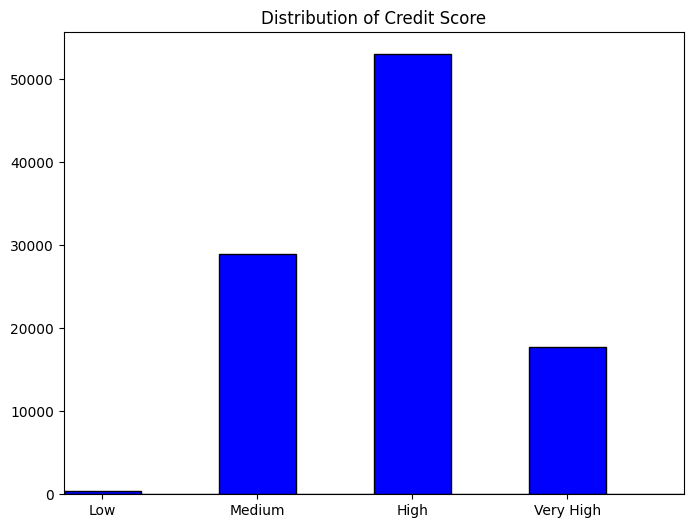

In [48]:
# Show the distribution of the target variable with an histogram
bins = np.arange(0, 4.5, 0.5)

target_variable = clean_credit_card_df['Credit_Score']

plt.figure(figsize=(8, 6))
plt.hist(target_variable, bins=bins, color='blue', alpha=1.0, edgecolor='black')
plt.title('Distribution of Credit Score')
plt.xticks([0.25, 1.25, 2.25, 3.25], ['Low', 'Medium', 'High', 'Very High'])
plt.xlim(0, 4)
plt.show()

The bar chart above displays the distribution of the `Credit Score` target variable across four categories: **Low**, **Medium**, **High**, and **Very High**. From the visualization, it's clear that:
- The **High** category is the most frequent, indicating that the dataset is heavily skewed toward individuals with high credit scores.
- The **Medium** and **Very High** categories follow, with **Medium** having a considerably larger count.
- The **Low** category is extremely underrepresented, with very few instances.

This imbalance may lead to biased model predictions, as most algorithms assume an even distribution of classes. To address this, we will need to apply techniques to balance the dataset, such as oversampling the minority class or undersampling the majority class.

### 2.1) Numerical Features Distribution

We will now visualize the distribution of the numerical features in the dataset. This will help us understand the range and distribution of values for each feature, identify any potential outliers, and assess whether any transformations or scaling are needed before training our model.

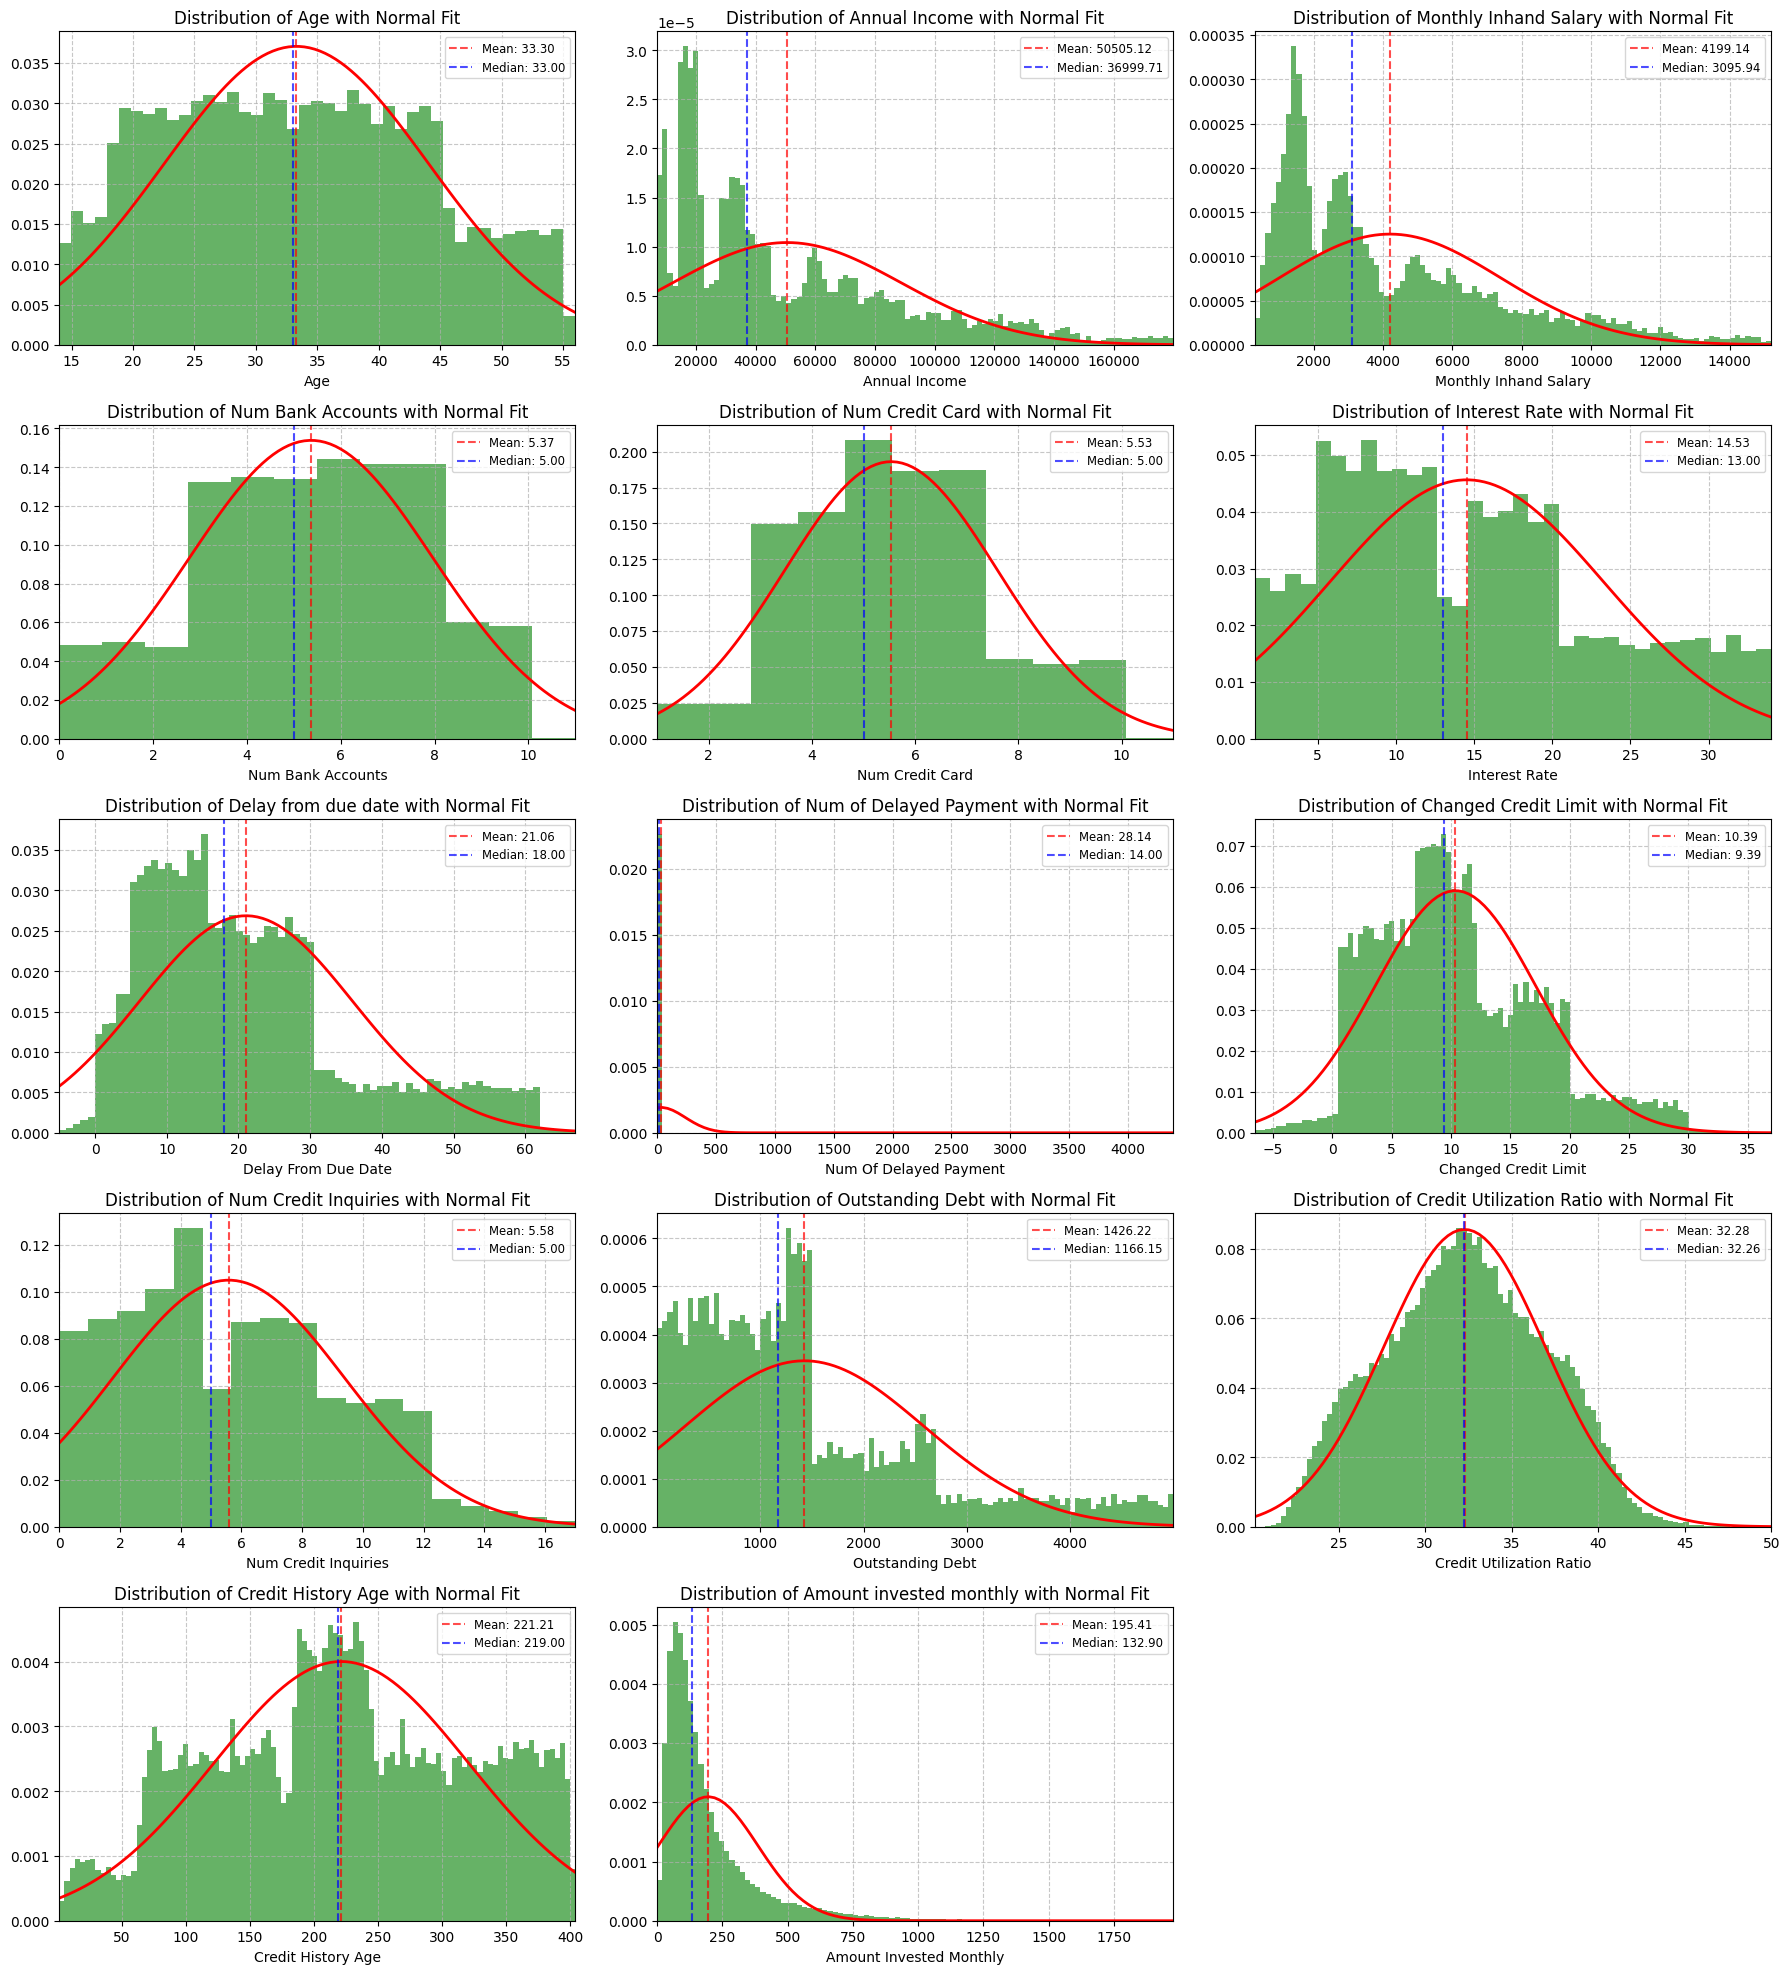

In [49]:
# Get the list of numerical feature names from the cleaned dataframe.
numeric_features = clean_credit_card_df.select_dtypes(include=['number']).columns
columns_to_drop = ['Credit_Score', 'Num_of_Loan'] + loan_columns
numeric_features = numeric_features.drop(columns_to_drop, errors='ignore')

n_features = len(numeric_features)

# Define grid size
n_cols = 3  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate required number of rows

# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through all numerical features and plot their distributions
for i, col in enumerate(numeric_features):
    ax = axes[i]
    data = clean_credit_card_df[col]
    
    # Plot histogram with density normalization
    n_bins = 0
    ax.hist(data, bins = min(len(data.unique()), 100), density=True, alpha=0.6, color='green')
    ax.set_xlim(data.min(), data.max())  # Set x-axis limits to focus on the range of interest
    
    # Fit a normal distribution to the data and plot it
    mu, std = norm.fit(data)
    x = np.linspace(data.min(), data.max(), 100)
    y = norm.pdf(x, mu, std)
    ax.plot(x, y, 'r-', lw=2)
    
    # Add vertical lines for mean and median
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='blue', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
    
    # Add legend, grid, and style ticks
    ax.legend(fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Set titles and labels
    ax.set_title(f'Distribution of {str(col).replace("_", " ")} with Normal Fit')
    ax.set_xlabel(str(col).replace('_', ' ').title())

# Remove any unused subplots if n_features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The plots above show the distributions of several numerical features in the dataset, overlaid with a normal (Gaussian) distribution for reference. Here are some key observations:

- **Normality**: Most variables deviate from a normal distribution, as evident by the skewed shapes of many histograms compared to the red normal fit curve.
  - Features like **Num_Bank_Accounts**, **Num_Credit_Card**, and **Credit_Utilization_Ratio** are fairly close to normal.
  - Others, such as **Annual_Income**, **Monthly_Inhand_Salary**, and **Amount_invested_monthly**, are **right-skewed**, indicating the presence of high-income outliers or a concentration of lower values.
  
- **Central Tendency**: Each plot includes the **mean** and **median**, which help illustrate the skewness:
  - In right-skewed distributions (e.g., **Annual_Income**, **Outstanding_Debt**), the **mean > median**, a common trait of positively skewed data.
  - For more symmetric distributions (e.g., **Credit_Utilization_Ratio**), the mean and median are close.

- **Outliers**: Several variables show long tails or sharp spikes that may indicate **potential outliers**—especially in features like **Num_Credit_Inquiries**, **Changed_Credit_Limit**, and **Delay_from_due_date**.

Overall, this visualization helps identify which features may need **normalization or transformation** (e.g., log scaling) before being used in a model. Additionally, skewed distributions might affect model performance and could be addressed depending on the algorithm used.

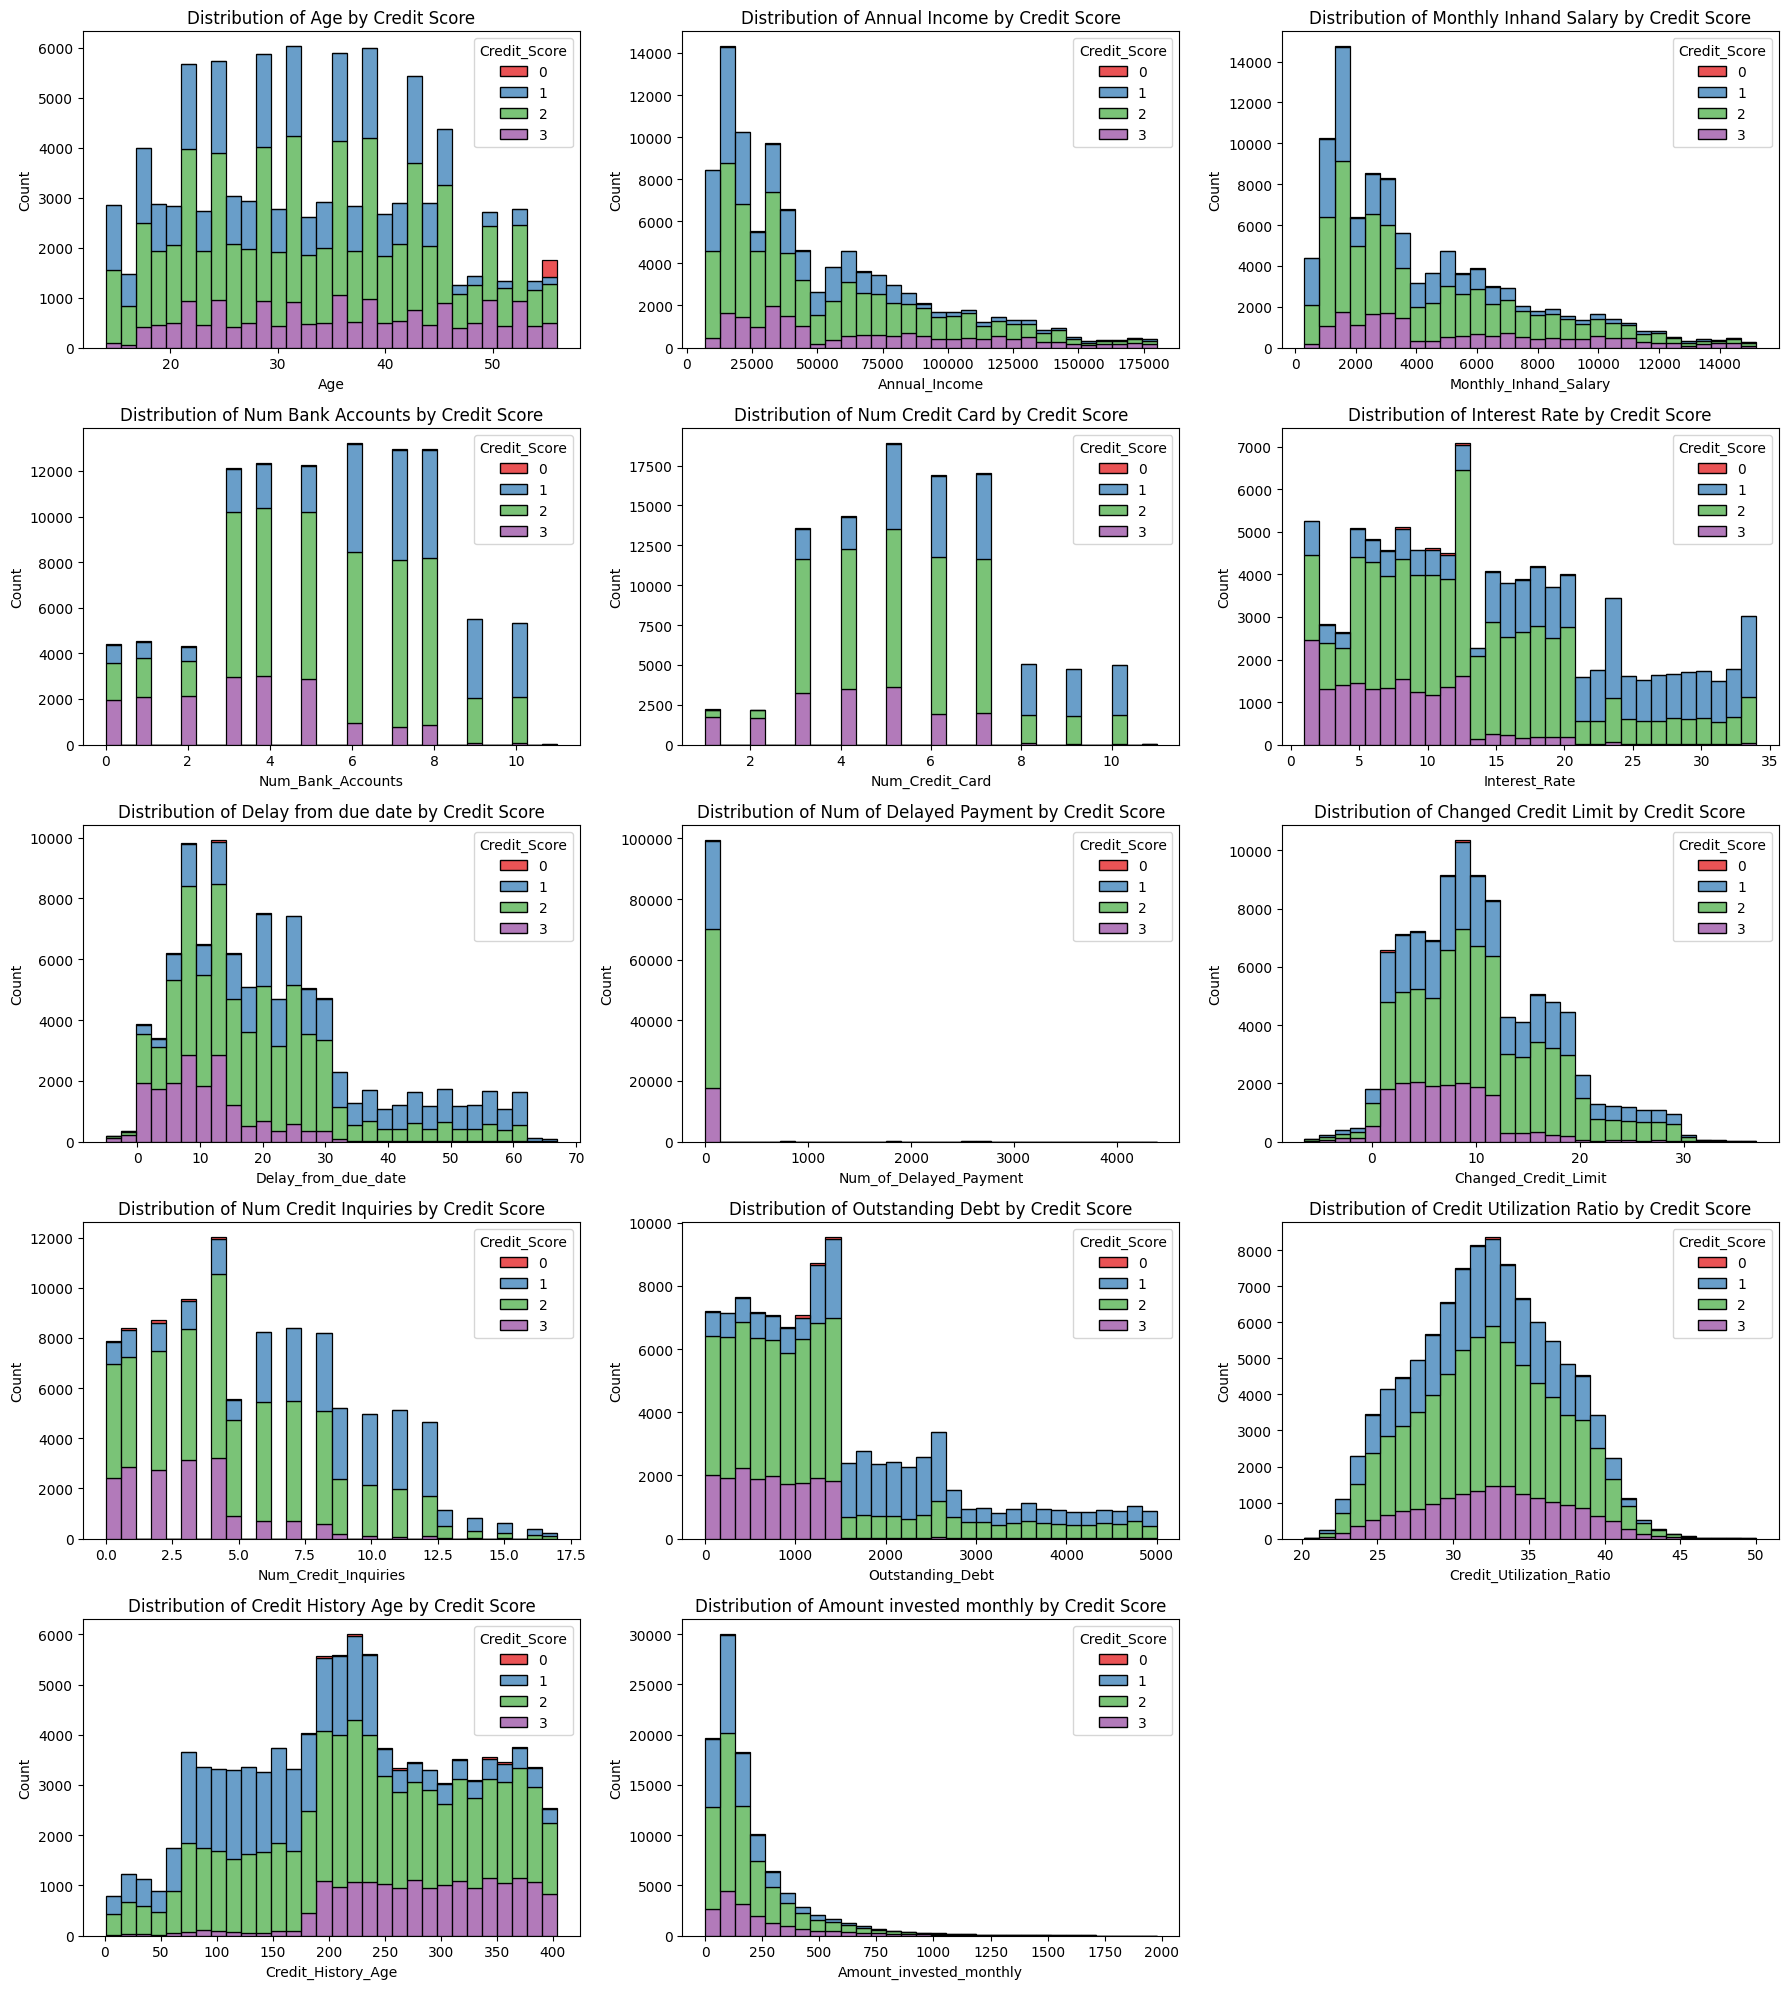

In [50]:
# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing


for i, col in enumerate(numeric_features):
    ax = axes[i]
    sns.histplot(data = clean_credit_card_df, x=col, hue = target_variable, multiple="stack", palette="Set1", bins= min(len(data.unique()), 30), ax=ax)
    ax.set_title(f'Distribution of {str(col).replace("_", " ")} by Credit Score')

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The above visualizations help identify how different credit score levels relate to various financial and behavioral features. By analyzing these relationships, we can gain insights into the factors influencing credit scores and potentially improve our model's performance. Here are some key observations from the visualizations:

1) The `Age` distribution is concentrated between 20 and 40 years, with most individuals scoring a 2. Credit score 3 (likely the lowest) appears infrequently across all ages, especially under 30. There's no strong age-based separation, suggesting age alone may not determine credit score. However, this is the only feature in whihc it is possible to distinguish the **Low** category from the others, indicating that older individuals tend to be associated with the latter. 

2) `Annual income` is highly right-skewed, with most individuals earning under $50,000. Higher scores (2 and 3) are more common in higher income brackets, while the worst scores (1) are more prevalent at lower incomes. This suggests a **positive correlation** between income and credit score.

3) `Monthly Inhand Salary `is similar to Annual Income, this variable is also skewed. Categories 2 and 3 dominate across all ranges, but especially above $3000/month. Low in-hand salaries are more frequently associated with score 0, reinforcing that disposable income may be a useful predictor.

4) `Num Bank Accounts`: most people have between 2 and 7 bank accounts. Higher scores (2 and 3) are more frequent in this range, while very low or very high account counts show a slightly higher proportion of poor scores (0). A balanced number of bank accounts appears more favorable.

5) `Num Credit Card`: Individuals with 3 to 8 credit cards are most common, with high scores (3) peaking in that range. Too few or too many credit cards (especially >10) show higher instances of score 0. Moderate credit card ownership may be associated with responsible credit use.

6) `Interest Rate` vary widely, but high interest rates (above 20%) are more likely associated with score 0. Lower interest rates (below 10%) are mostly tied to scores 2 and 3. This likely reflects lenders assigning lower rates to more creditworthy individuals.

7) `Delay from due date`: Most delays are under 25 days. Individuals with fewer days delayed tend to have higher scores, especially 3. As delay increases, score 0 becomes more frequent. This shows that **late payments significantly reduce credit score**.

8) `Num of Delayed Payment`: There’s a large spike at 0 delayed payments, which is heavily associated with score 3. As the number of delayed payments increases, the proportion of score 0 rises sharply. This is a **strong indicator** of credit risk.

9) `Changed Credit Limit`: Most people have a moderate change in credit limit (5–15). Scores 2 and 3 dominate here, but large changes (especially above 20) appear more with lower scores. This might reflect reactive credit changes following poor behavior.

10) `Num Credit Inquiries`: Fewer inquiries (0–5) are clearly associated with high scores (2 and 3), while a higher number of inquiries (10+) correlate with score 0. This supports the idea that **excessive credit seeking is a negative signal**.

11)  `Outstanding Debt`: Debt is highly skewed. Individuals with lower outstanding debt tend to have better scores. As debt increases beyond 2000, score 0 becomes more prevalent. **Higher debt burden appears to be a risk factor**.

12)  `Credit Utilization Ratio`: This is one of the most telling features. Scores 3 and 2 cluster around utilization rates of 25–35%, while scores 0 increase with higher utilization (above 40%). **Lower utilization aligns with better creditworthiness**, as expected.

13)  `Credit History Age`: A longer credit history (150–300) corresponds to higher scores. Shorter histories (under 100) see more score 0 entries. This follows the expected pattern where longer credit history suggests greater reliability.

14)  `Amount invested monthly`: This feature is skewed right. Higher credit scores (2 and 3) are more common among those who invest regularly, especially above $300/month. Individuals with no or very low investments are more likely to have poor scores, suggesting that **financial planning behavior contributes positively to creditworthiness**.


**Summary**:  
The most informative features for separating credit score categories appear to be:
- `Num of Delayed Payment`
- `Delay from due date`
- `Credit Utilization Ratio`
- `Num Credit Inquiries`
- `Amount invested monthly`

These behaviors closely reflect typical financial risk factors used in real-world credit scoring.

## 2.2) Categorical Features Distribution

We will now visualize the distribution of the categorical features in the dataset. This will help us understand how different categories relate to the target variable and identify any potential issues with the data.

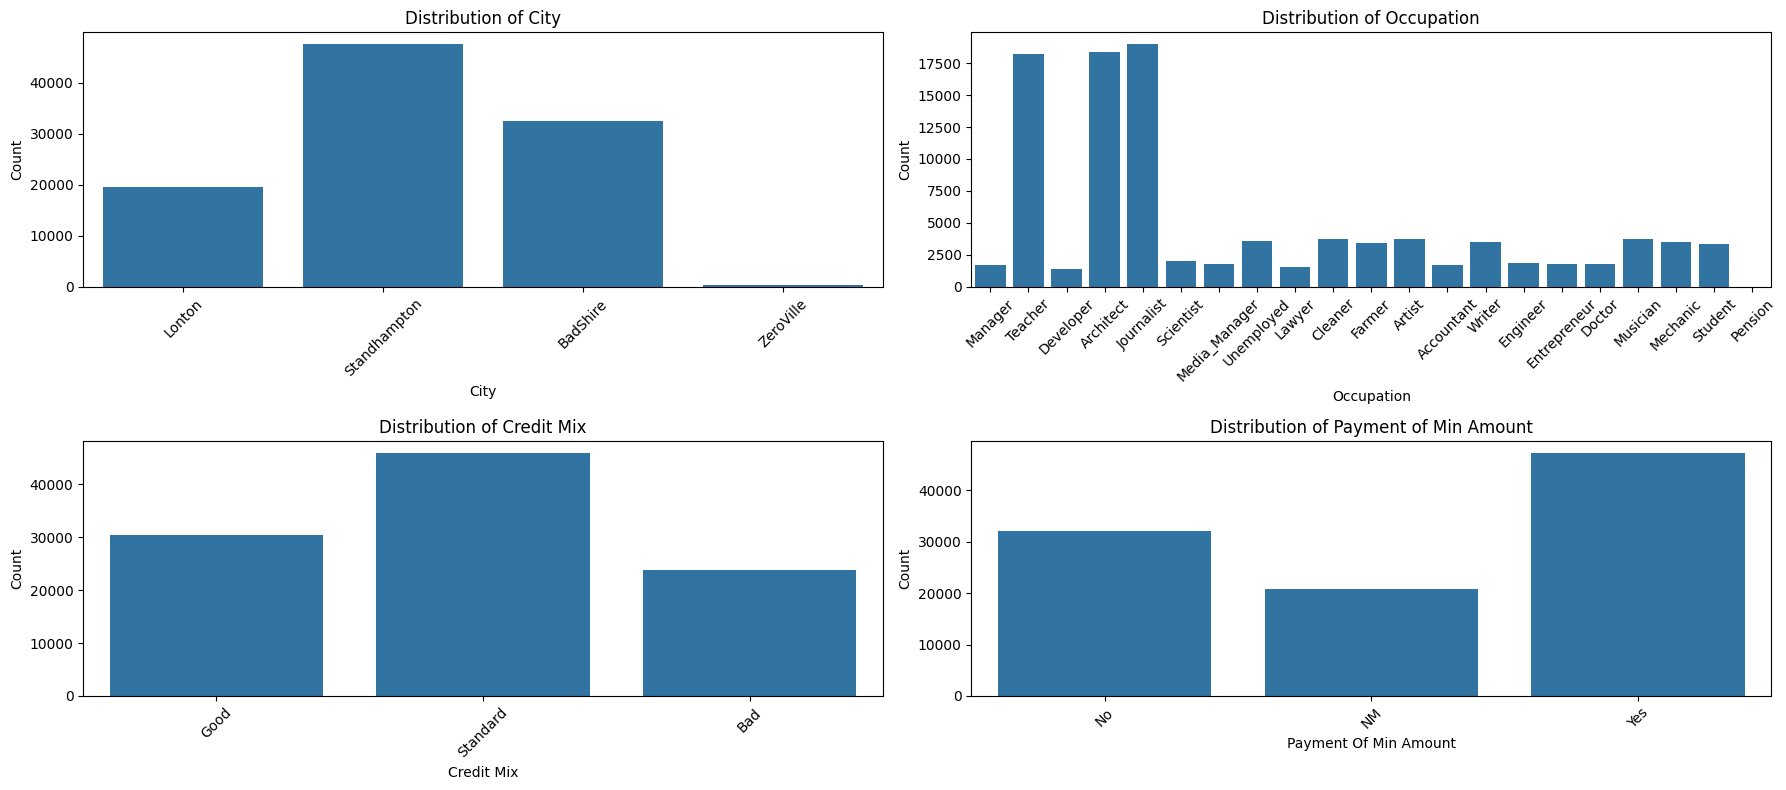

In [59]:
categorical_features = clean_credit_card_df.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop("Address")

# Plot the distribution of categorical features
n_features = len(categorical_features)

# Define grid size
n_cols = 2  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate required number of rows

# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through all categorical features and plot their distributions
for i, col in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data=clean_credit_card_df, x=col, ax=ax)
    ax.set_title(f'Distribution of {str(col).replace("_", " ")}')
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


    
    


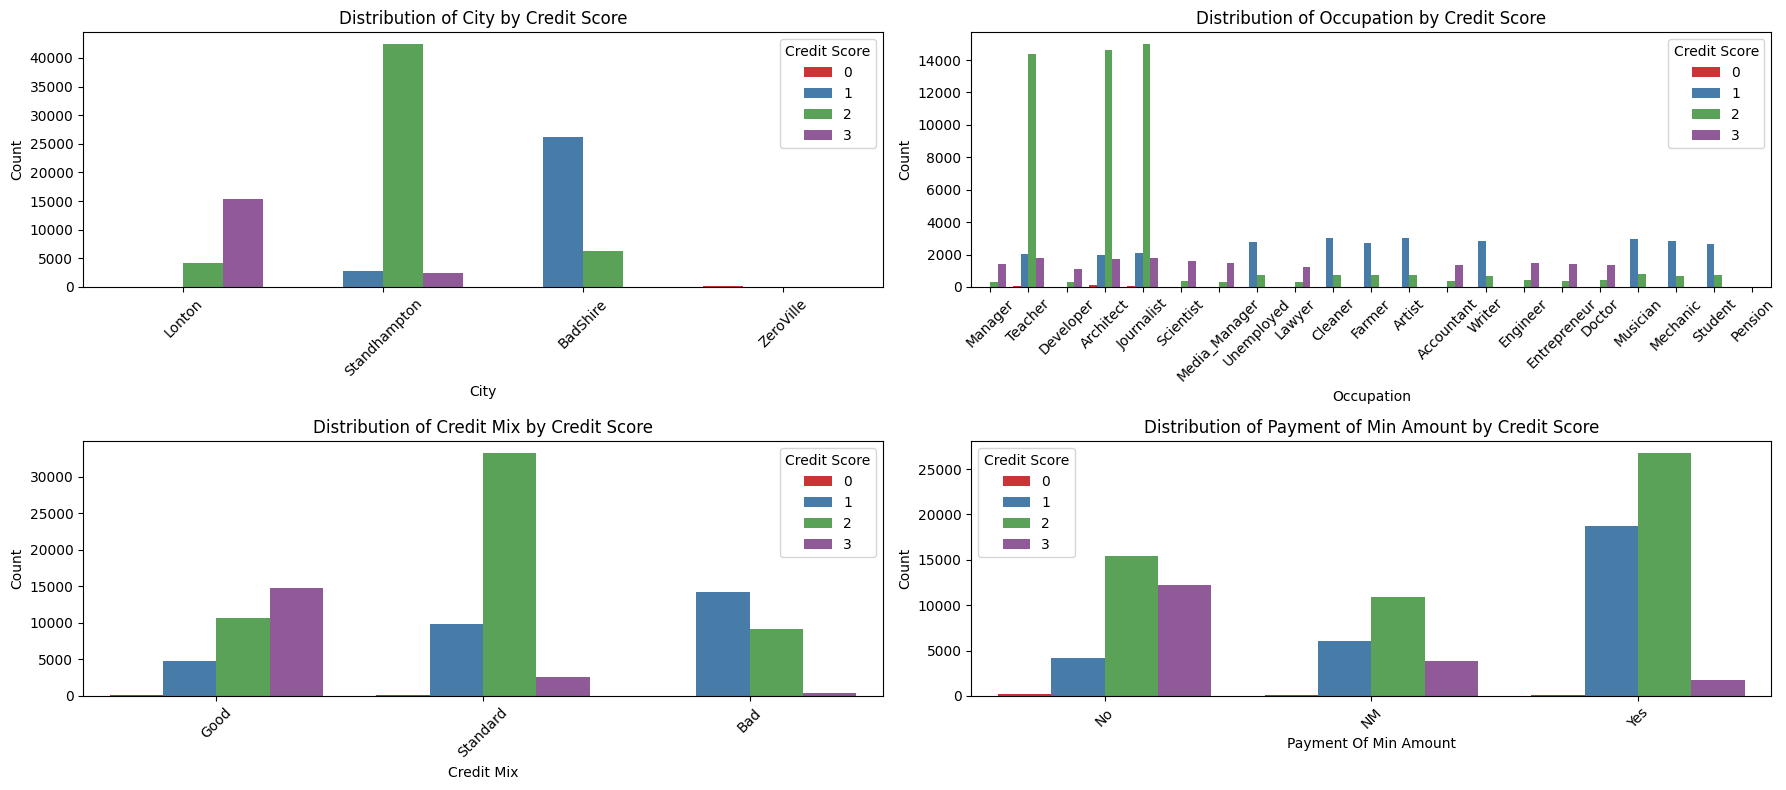

In [62]:
# Plot the distribution of categorical features by target (Credit_Score)
n_features = len(categorical_features)
n_cols = 2  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data=clean_credit_card_df, x=col, hue='Credit_Score', ax=ax, palette="Set1")
    ax.set_title(f'Distribution of {col.replace("_", " ")} by Credit Score')
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Credit Score')

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
## Removing outliers from the dataset

def remove_outliers(df, column):
    """
    Remove outliers from a specified column in a DataFrame using the IQR method.
    
    Parameters:
      df: pandas DataFrame
      column: Column name from which to remove outliers
      
    Returns:
      A new DataFrame with outliers removed from the specified column.
    """
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR
    
    # Filter the DataFrame to remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Shape of the DataFrame before removing outliers: {credit_card_df.shape}")

# Loop through each numerical feature and remove outliers
for col in numerical_features:
    cleaned_credit_card_df = remove_outliers(cleaned_credit_card_df, col)

# Display the shape of the DataFrame after removing outliers
print(f"Shape of the DataFrame after removing outliers: {cleaned_credit_card_df.shape}")